In [34]:
import json

import numpy as np

from pathlib import Path

from overcast import models
from overcast import datasets
from overcast.models import ensembles

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
color_list = ['C8', 'C7', 'C6', 'C5', 'C4', 'C3', 'C2', 'C1']

In [46]:
class Experiment:
    def __init__(self, experiment_path, name):
        self.experiment_dir = Path(experiment_path)
        self.transformer = True if "daily" in experiment_path else False
        config_path = self.experiment_dir / "config.json"
        self.checkpoint_dir = self.experiment_dir / "checkpoints"
        self.ensemble_dir = self.experiment_dir
        self.name = name

        with open(config_path) as cp:
            config = json.load(cp)

        self.dataset_name = config.get("dataset_name")
        self.num_components_outcome = config.get("num_components_outcome")
        self.num_components_treatment = config.get("num_components_treatment")
        self.dim_hidden = config.get("dim_hidden")
        self.depth = config.get("depth")
        self.negative_slope = config.get("negative_slope")
        self.beta = config.get("beta")
        self.layer_norm = config.get("layer_norm")
        self.dropout_rate = config.get("dropout_rate")
        self.spectral_norm = config.get("spectral_norm")
        self.learning_rate = config.get("learning_rate")
        self.batch_size = config.get("batch_size")
        self.epochs = config.get("epochs")
        self.ensemble_size = config.get("ensemble_size")
        self.num_heads = config.get("num_heads") if self.transformer is True else None

        self.ds = {
            "test": datasets.DATASETS.get(self.dataset_name)(**config.get("ds_test")),
            "valid": datasets.DATASETS.get(self.dataset_name)(**config.get("ds_valid")),
            "train": datasets.DATASETS.get(self.dataset_name)(**config.get("ds_train")),
        }

        self.target_keys = dict(
            (k, v) for (k, v) in enumerate(self.ds["test"].target_names)
        )

        ensemble = self.load_ensemble()
        treatments = self.load_treatments()
        apos_ensemble = self.load_apos_ensemble()

        self.ensemble = ensemble
        self.treatments = treatments
        self.apos_ensemble = apos_ensemble

        self.apo_limits = {}

    def load_ensemble(self):
        if self.transformer:
            return self.load_transformer_ensemble()
        else:
            return self.load_nn_ensemble()

    def load_transformer_ensemble(self):
        ensemble = []
        for ensemble_id in range(self.ensemble_size):
            model_dir = self.checkpoint_dir / f"model-{ensemble_id}" / "mu"
            model = models.AppendedTreatmentAttentionNetwork(
                job_dir=model_dir,
                dim_input=self.ds["train"].dim_input,
                dim_treatment=self.ds["train"].dim_treatments,
                dim_output=self.ds["train"].dim_targets,
                num_components_outcome=self.num_components_outcome,
                num_components_treatment=self.num_components_treatment,
                dim_hidden=self.dim_hidden,
                depth=self.depth,
                num_heads=self.num_heads,
                negative_slope=self.negative_slope,
                beta=self.beta,
                layer_norm=self.layer_norm,
                spectral_norm=self.spectral_norm,
                dropout_rate=self.dropout_rate,
                num_examples=len(self.ds["train"]),
                learning_rate=self.learning_rate,
                batch_size=self.batch_size,
                epochs=self.epochs,
                patience=50,
                num_workers=0,
                seed=ensemble_id,
            )
            model.load()
            ensemble.append(model)
        return ensemble

    def load_nn_ensemble(self):
        ensemble = []
        for ensemble_id in range(self.ensemble_size):
            model_dir = self.checkpoint_dir / f"model-{ensemble_id}" / "mu"
            model = models.AppendedTreatmentNeuralNetwork(
                job_dir=model_dir,
                architecture="resnet",
                dim_input=self.ds["train"].dim_input,
                dim_treatment=self.ds["train"].dim_treatments,
                dim_output=self.ds["train"].dim_targets,
                num_components_outcome=self.num_components_outcome,
                num_components_treatment=self.num_components_treatment,
                dim_hidden=self.dim_hidden,
                depth=self.depth,
                negative_slope=self.negative_slope,
                beta=self.beta,
                layer_norm=self.layer_norm,
                spectral_norm=self.spectral_norm,
                dropout_rate=self.dropout_rate,
                num_examples=len(self.ds["train"]),
                learning_rate=self.learning_rate,
                batch_size=self.batch_size,
                epochs=self.epochs,
                patience=self.epochs,
                num_workers=0,
                seed=ensemble_id,
            )
            model.load()
            ensemble.append(model)
        return ensemble

    def load_treatments(self):
        if self.transformer:
            return self.load_transformer_treatments()
        else:
            return self.load_nn_treatments()

    def load_transformer_treatments(self):
        treatments = np.concatenate(self.ds["train"].treatments, axis=0)
        treatments = self.ds["train"].treatments_xfm.inverse_transform(treatments)
        treatments = np.quantile(treatments, q=np.arange(0, 1 + 1 / 32, 1 / 32),)[:-1]
        return treatments

    def load_nn_treatments(self):
        treatments = np.quantile(
            self.ds["train"].treatments_xfm.inverse_transform(
                self.ds["train"].treatments
            ),
            q=np.arange(0, 1 + 1 / 32, 1 / 32),
        )[:-1]
        return treatments

    def load_apos_ensemble(self):
        apos_ensemble_path = self.ensemble_dir / "apos_ensemble.npy"
        if not apos_ensemble_path.exists():
            capos_ensemble = ensembles.predict_capos(
                ensemble=self.ensemble,
                dataset=self.ds["test"],
                treatments=self.treatments,
                batch_size=1 if self.transformer else 20000,
            )
            apos_ensemble = capos_ensemble.mean(2)
            np.save(apos_ensemble_path, apos_ensemble)
        else:
            apos_ensemble = np.load(apos_ensemble_path)
        return apos_ensemble

    def get_apo_limits(self, log_lambda):
        apo_limits_path = self.ensemble_dir / f"apo_limits_{log_lambda}.npy"
        if not apo_limits_path.exists():
            lower_capos, upper_capos = ensembles.predict_intervals(
                ensemble=self.ensemble,
                dataset=self.ds["test"],
                treatments=self.treatments,
                log_lambda=log_lambda,
                num_samples=100,
                batch_size=1 if self.transformer else 10000,
            )
            lower_apos = np.expand_dims(lower_capos.mean(2), 0)
            upper_apos = np.expand_dims(upper_capos.mean(2), 0)
            apo_limits = np.concatenate([lower_apos, upper_apos], axis=0)
            np.save(apo_limits_path, apo_limits)
        else:
            apo_limits = np.load(apo_limits_path)
        self.apo_limits[log_lambda] = apo_limits

    def get_apo_limits_from_scratch(self, log_lambda):
        apo_limits_path = self.ensemble_dir / f"apo_limits_{log_lambda}.npy"
        lower_capos, upper_capos = ensembles.predict_intervals(
            ensemble=self.ensemble,
            dataset=self.ds["test"],
            treatments=self.treatments,
            log_lambda=log_lambda,
            num_samples=100,
            batch_size=1 if self.transformer else 10000,
        )
        lower_apos = np.expand_dims(lower_capos.mean(2), 0)
        upper_apos = np.expand_dims(upper_capos.mean(2), 0)
        apo_limits = np.concatenate([lower_apos, upper_apos], axis=0)
        np.save(apo_limits_path, apo_limits)
        self.apo_limits[log_lambda] = apo_limits


def plot_apos(reference_experiment, comparison_experiments, apo_limits_log_lambda_list):
    alpha = 0.05
    _, ax = plt.subplots(2, 2, figsize=(12, 12))
    for idx_outcome in range(len(reference_experiment.target_keys)):
        i, j = idx_outcome // 2, idx_outcome % 2
        # plot comparison experiments APOs
        for k in range(len(comparison_experiments)):
            scaler = MinMaxScaler()
            scaler = scaler.fit(
                comparison_experiments[k]
                .apos_ensemble[idx_outcome]
                .mean(0)
                .reshape(-1, 1)
            )
            _ = ax[i][j].plot(
                comparison_experiments[k].treatments,
                scaler.transform(
                    comparison_experiments[k]
                    .apos_ensemble[idx_outcome]
                    .mean(0)
                    .reshape(-1, 1)
                ),
                label=comparison_experiments[k].name,
            )
        reference_scaler = MinMaxScaler()
        reference_scaler = reference_scaler.fit(
            reference_experiment.apos_ensemble[idx_outcome].mean(0).reshape(-1, 1)
        )
        _ = ax[i][j].plot(
            reference_experiment.treatments,
            reference_scaler.transform(
                reference_experiment.apos_ensemble[idx_outcome].mean(0).reshape(-1, 1)
            ),
            label=reference_experiment.name,
        )
        for l in apo_limits_log_lambda_list:
            if l not in reference_experiment.apo_limits:
                reference_experiment.get_apo_limits(l)
        for idx in range(len(apo_limits_log_lambda_list)-1):
            l = apo_limits_log_lambda_list[idx]
            next_l = apo_limits_log_lambda_list[idx + 1]
            _ = ax[i][j].fill_between(
                x=reference_experiment.treatments,
                y1=reference_scaler.transform(
                    np.quantile(
                        reference_experiment.apo_limits[l][1][idx_outcome],
                        1 - alpha / 2,
                        axis=0,
                    ).reshape(-1, 1)
                ).flatten(),
                y2=reference_scaler.transform(
                    np.quantile(
                        reference_experiment.apo_limits[next_l][1][idx_outcome],
                        1 - alpha / 2,
                        axis=0,
                    ).reshape(-1, 1)
                ).flatten(),
                alpha=0.2,
                color=color_list[-3-idx],
                label=r"$\Lambda=$" + f"{np.exp(l):.2f}",
            )
            _ = ax[i][j].fill_between(
                x=reference_experiment.treatments,
                y1=reference_scaler.transform(
                    np.quantile(
                        reference_experiment.apo_limits[l][0][idx_outcome],
                        alpha / 2,
                        axis=0,
                    ).reshape(-1, 1)
                ).flatten(),
                y2=reference_scaler.transform(
                    np.quantile(
                        reference_experiment.apo_limits[next_l][0][idx_outcome],
                        alpha / 2,
                        axis=0,
                    ).reshape(-1, 1)
                ).flatten(),
                alpha=0.2,
                color=color_list[-3-idx],
            )
        last = apo_limits_log_lambda_list[-1]
        _ = ax[i][j].fill_between(
            x=reference_experiment.treatments,
            y1=reference_scaler.transform(
                np.quantile(
                    reference_experiment.apo_limits[last][1][idx_outcome],
                    1 - alpha / 2,
                    axis=0,
                ).reshape(-1, 1)
            ).flatten(),
            y2=reference_scaler.transform(
                np.quantile(
                    reference_experiment.apos_ensemble[idx_outcome],
                    1 - alpha / 2,
                    axis=0
                ).reshape(-1, 1)
            ).flatten(),
            alpha=0.2,
            color=color_list[-2],
        )
        _ = ax[i][j].fill_between(
            x=reference_experiment.treatments,
            y1=reference_scaler.transform(
                np.quantile(
                    reference_experiment.apo_limits[last][0][idx_outcome],
                    alpha / 2,
                    axis=0,
                ).reshape(-1, 1)
            ).flatten(),
            y2=reference_scaler.transform(
                np.quantile(
                    reference_experiment.apos_ensemble[idx_outcome],
                    alpha / 2,
                    axis=0
                ).reshape(-1, 1)
            ).flatten(),
            alpha=0.2,
            color=color_list[-2],
            label=r"$\Lambda=$" + f"{np.exp(last):.2f}",
        )
        _ = ax[i][j].fill_between(
            x=reference_experiment.treatments,
            y1=reference_scaler.transform(
                np.quantile(
                    reference_experiment.apos_ensemble[idx_outcome],
                    1 - alpha / 2,
                    axis=0,
                ).reshape(-1, 1)
            ).flatten(),
            y2=reference_scaler.transform(
                np.quantile(
                    reference_experiment.apos_ensemble[idx_outcome],
                    alpha / 2,
                    axis=0,
                ).reshape(-1, 1)
            ).flatten(),
            alpha=0.2,
            color=color_list[-1],
            label=r"$\Lambda \to 1.0 $",
        )
        _ = ax[i][j].legend(title=r"$\alpha=$" + f"{alpha}", loc="upper left",)
        _ = ax[i][j].set_xlabel(reference_experiment.ds["train"].treatment_names[0])
        _ = ax[i][j].set_ylabel(reference_experiment.target_keys[idx_outcome])
    # plt.savefig(f"results/{reference_experiment.name}-{apo_limits_log_lambda_list[0]}.pdf")
    plt.show()

In [59]:
tr_pacific = Experiment(
    "/users/ms21mmso/msc-project/overcast/output/jasmin-daily-four_outputs_liqcf_pacific_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-transformer/dh-128_nco-22_nct-27_dp-3_nh-8_ns-0.28_bt-0.0_ln-False_dr-0.42_sn-0.0_lr-0.0001_bs-128_ep-500",
    "pacific",
)

tr_atlantic = Experiment(
    "/users/ms21mmso/msc-project/overcast/output/jasmin-daily-four_outputs_liqcf_atlantic_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-transformer/dh-128_nco-24_nct-7_dp-4_nh-8_ns-0.19_bt-0.0_ln-True_dr-0.16_sn-0.0_lr-0.0001_bs-160_ep-500",
    "atlantic",
)

2022-07-27 03:21:04,607 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /users/ms21mmso/msc-project/overcast/output/jasmin-daily-four_outputs_liqcf_pacific_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-transformer/dh-128_nco-22_nct-27_dp-3_nh-8_ns-0.28_bt-0.0_ln-False_dr-0.42_sn-0.0_lr-0.0001_bs-128_ep-500/checkpoints/model-0/mu/best_checkpoint.pt
/users/ms21mmso/miniconda3/envs/overcast/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
2022-07-27 03:21:08,331 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /users/ms21mmso/msc-project/overcast/output/jasmin-daily-four_outputs_liqcf_pacific_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-

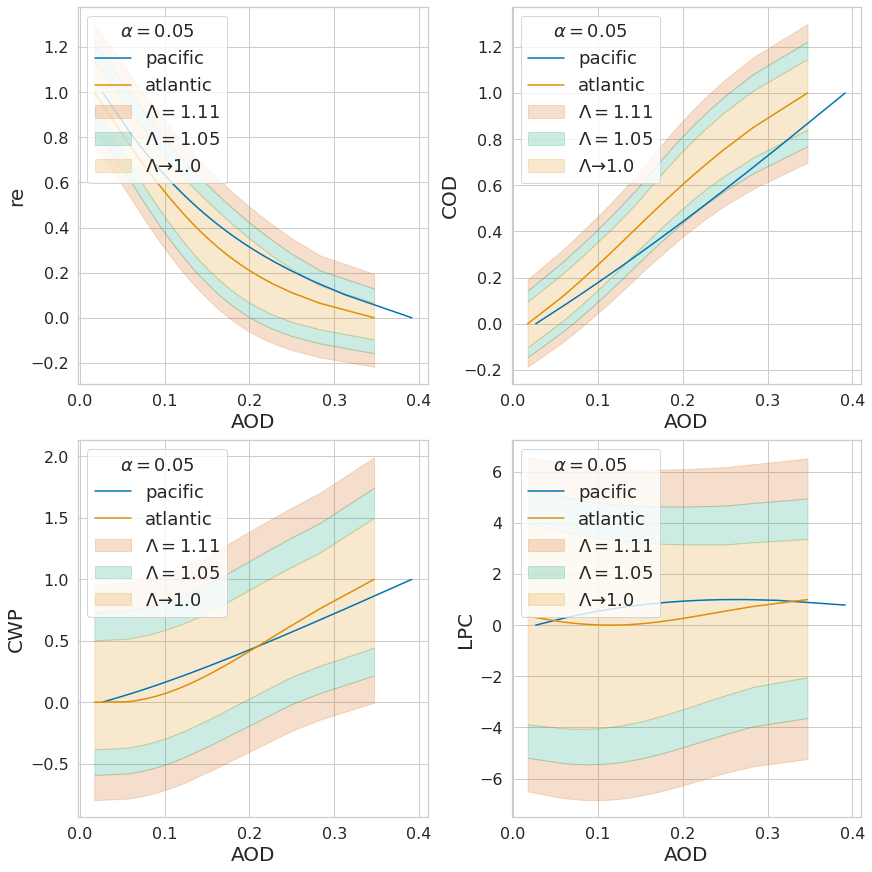

In [63]:
plot_apos(tr_atlantic, [tr_pacific], [0.1, 0.05])